# Testing the RDF->S(Q) Against Debye for Discrete Systems

On 2-particle, 3-particle, and bigger systems. 

Using VMD-generated RDFs, because MD Analysis cannot create RDFs that have good enough delta-peak characteristics


In [120]:
%reset -f
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

import sys, glob
sys.path.append('../')

import matplotlib, glob, os
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage{cmbright}')
matplotlib.rc('axes.formatter', limits= (-2, 2))
plt.rcParams.update({'figure.autolayout': True})
plt.rcParams.update({'font.size': 16})

import MDAnalysis as mda 
from MDAnalysis.analysis.rdf import InterRDF

from cmm.xray.sgr import SGr, Damping
from cmm.xray.sgr2 import RDF, SGr as SGr2, rdfset_from_dir

from cmm.xray.debye import Debye

from ase.io import read

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2 Particle Solute 

Bookkeeping messages:
---------------------
---------------------

Second term:
------------
SOLUTE  : Pt_u:      2 - Pt_u:      2, KD:1.0


<IPython.core.display.Javascript object>


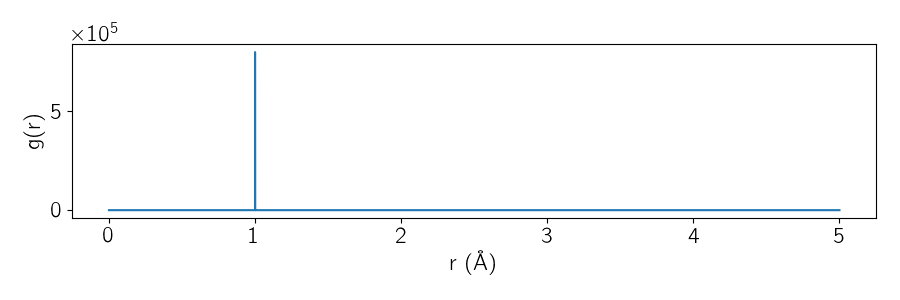

<IPython.core.display.Javascript object>


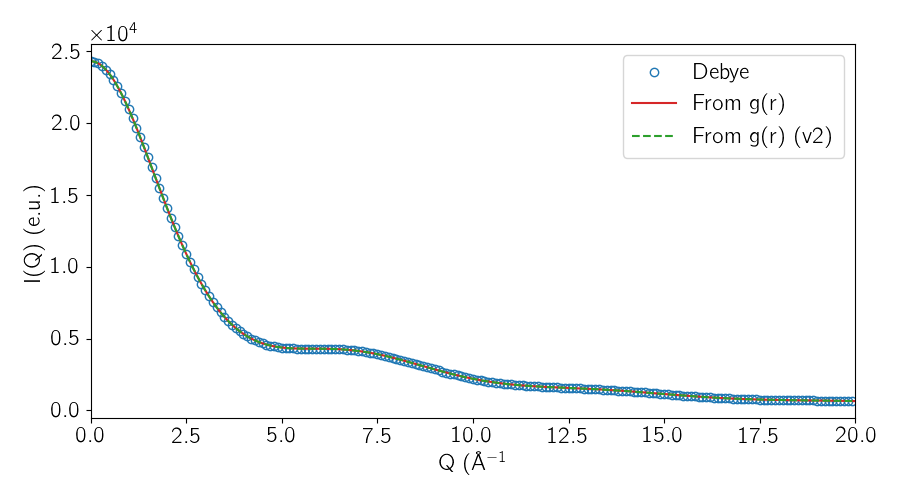

In [121]:
atoms = read('../data/test/xray_2particle/test.xyz')
deb = Debye(qvec=np.arange(0, 20, 0.01))
s_deb = deb.debye(atoms)

stoich = {'Pt_u':2}
V = 10**3
sgr = SGr(V, damp=None, delta=False, verbose=True, qvec=deb.qvec)
sgr.load_rdfs_fromdir('../data/test/xray_2particle/')
s_sgr = sgr.calculate(sgr.rdfs, stoich)

# SGr2
rdf_obj = RDF(sgr.rdfs[0]['r'], sgr.rdfs[0]['gr'], 'Pt', 'Pt', 'solute', 'solute')
rdf_obj.n1 = 2
rdf_obj.n2 = 2
rdf_obj.volume = V
sgr2 = SGr2(V, qvec=deb.qvec)
sg2 = sgr2.i_term2(rdf_obj)
sg2 += 2 * rdf_obj.f0_1**2

ptpt_rdf = np.genfromtxt('../data/test/xray_2particle/gPt_u-Pt_u.dat')
fig, ax = plt.subplots(1, 1, figsize=(9, 3)) 
ax.plot(ptpt_rdf[:, 0 ], ptpt_rdf[:, 1])
ax.set_ylabel('g(r)')
ax.set_xlabel('r (Å)')
fig.tight_layout()

fig, ax = plt.subplots(1, 1, figsize=(9, 5)) 
ax.plot(deb.qvec[::10], s_deb[::10], 'C0o', label='Debye', mfc='None')
ax.plot(s_sgr['q'], s_sgr['s_u'], 'C3-', label='From g(r)')
ax.plot(deb.qvec,  sg2, 'C2--', label='From g(r) (v2)')

ax.set_xlim([0, 20])
ax.set_xlabel('Q (Å$^{-1}$')
ax.set_ylabel('I(Q) (e.u.)')
ax.legend(loc='best');
fig.tight_layout()



### 3 Particle system, Pt,Pt, Ar, RDFs from VMD

<IPython.core.display.Javascript object>


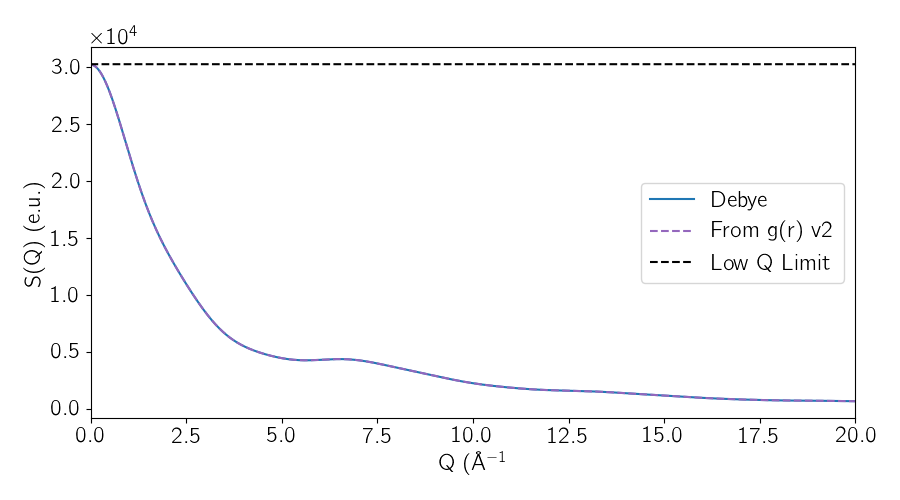

In [122]:
rdf_PtPt = np.genfromtxt('../data/test/xray_3particle/gPt_u-Pt_u.dat')
rdf_ArPt = np.genfromtxt('../data/test/xray_3particle/gAr_u-Pt_u.dat')
rdf_PtAr = np.genfromtxt('../data/test/xray_3particle/gPt_u-Ar_u.dat')

rdf_obj_PtPt = RDF(rdf_PtPt[:, 0], rdf_PtPt[:, 1], 'Pt', 'Pt', 'solute', 'solute')
rdf_obj_PtPt.n1 = 2
rdf_obj_PtPt.n2 = 2

rdf_obj_ArPt = RDF(rdf_ArPt[:, 0], rdf_ArPt[:, 1], 'Ar', 'Pt', 'solute', 'solute')
rdf_obj_ArPt.n1 = 1
rdf_obj_ArPt.n2 = 2

rdf_obj_PtAr = RDF(rdf_PtAr[:, 0], rdf_PtAr[:, 1], 'Pt', 'Ar', 'solute', 'solute')
rdf_obj_PtAr.n1 = 2
rdf_obj_PtAr.n2 = 1

qvec = np.arange(0, 20, 0.01)

atoms = read('../data/test/xray_3particle/ptptar.xyz')
deb = Debye(qvec=qvec)
s_deb = deb.debye(atoms)
num_electrons_squared = sum(atoms.get_atomic_numbers())**2

sgr2 = SGr2(10**3, qvec=qvec)
s_g2 = np.zeros(len(sgr2.qvec))

for rdf_obj in (rdf_obj_PtPt, rdf_obj_ArPt, rdf_obj_PtAr):
    s_g2 += sgr2.i_term2(rdf_obj)
    
s_g2 += 2 * rdf_obj_PtPt.f0_1**2
s_g2 += rdf_obj_ArPt.f0_1**2

fig, ax = plt.subplots(1, 1, figsize=(9, 5)) 
ax.plot(deb.qvec, s_deb, 'C0', label='Debye')
ax.plot(sgr2.qvec, s_g2, 'C4--', label='From g(r) v2')
ax.plot(deb.qvec, np.ones_like(deb.qvec) * num_electrons_squared, 'k--', label='Low Q Limit')
ax.set_xlim([0, 20])
ax.set_xlabel('Q (Å$^{-1}$')
ax.set_ylabel('S(Q) (e.u.)')
ax.legend(loc='best');
fig.tight_layout()


### 3 Particle system again, using the RDFSet() class

In [123]:
rdfs = rdfset_from_dir('../data/test/xray_3particle/', '../data/test/xray_3particle/ptptar.xyz', volume=10**3)
rdfs.show()

|  #  | KEY                   |     STOICHOMETRY     | REGION1, REGION2 | VOLUME 
| 000 | Ar-solute--Pt-solute  | N1:     1, N2:     2 | solute , solute  | 1000.0000 |
| 001 | Pt-solute--Ar-solute  | N1:     2, N2:     1 | solute , solute  | 1000.0000 |
| 002 | Pt-solute--Pt-solute  | N1:     2, N2:     2 | solute , solute  | 1000.0000 |


  0%|          | 0/3 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


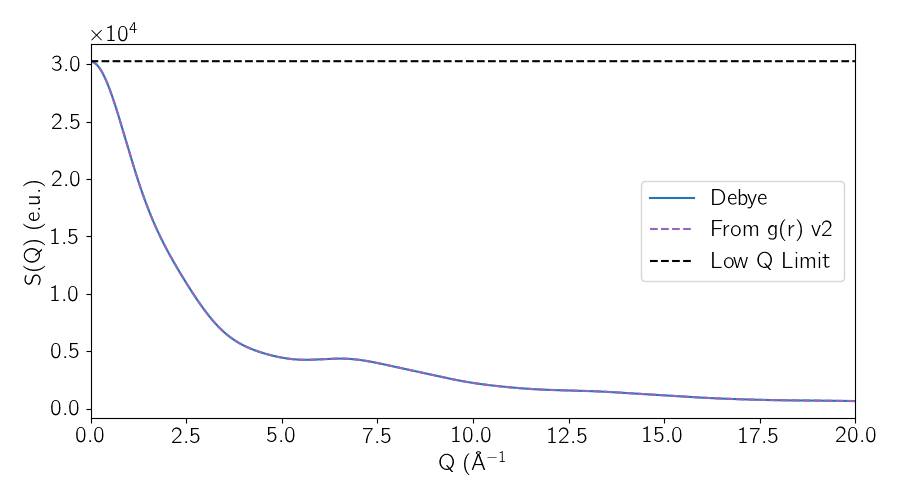

In [124]:
qvec = np.arange(0, 20, 0.01)

atoms = read('../data/test/xray_3particle/ptptar.xyz')
deb = Debye(qvec=qvec)
s_deb = deb.debye(atoms)
num_electrons_squared = sum(atoms.get_atomic_numbers())**2

s_g2 = rdfs.get_iq(qvec)


fig, ax = plt.subplots(1, 1, figsize=(9, 5)) 
ax.plot(qvec, s_deb, 'C0', label='Debye')
ax.plot(qvec, s_g2, 'C4--', label='From g(r) v2')
ax.plot(qvec, np.ones_like(qvec) * num_electrons_squared, 'k--', label='Low Q Limit')
ax.set_xlim([0, 20])
ax.set_xlabel('Q (Å$^{-1}$')
ax.set_ylabel('S(Q) (e.u.)')
ax.legend(loc='best');
fig.tight_layout()

### Scattering from one of of the larger molecules in ../data

RDFs generated using vmd: `vmd -dipsdev none -e -eofexit ../data/test/xray_agptpop/get_rdfs.tcl` 

In [144]:
rdfs = rdfset_from_dir('../data/test/xray_agptpop/', '../data/md/agptpop/agptpop_dry.prmtop', volume=25**3)
rdfs.show()

|  #  | KEY                   |     STOICHOMETRY     | REGION1, REGION2 | VOLUME 
| 000 | Ag-solute--H-solute   | N1:     1, N2:     8 | solute , solute  | 15625.0000 |
| 001 | Ag-solute--O-solute   | N1:     1, N2:    20 | solute , solute  | 15625.0000 |
| 002 | Ag-solute--P-solute   | N1:     1, N2:     8 | solute , solute  | 15625.0000 |
| 003 | Ag-solute--Pt-solute  | N1:     1, N2:     2 | solute , solute  | 15625.0000 |
| 004 | H-solute--Ag-solute   | N1:     8, N2:     1 | solute , solute  | 15625.0000 |
| 005 | H-solute--H-solute    | N1:     8, N2:     8 | solute , solute  | 15625.0000 |
| 006 | H-solute--O-solute    | N1:     8, N2:    20 | solute , solute  | 15625.0000 |
| 007 | H-solute--P-solute    | N1:     8, N2:     8 | solute , solute  | 15625.0000 |
| 008 | H-solute--Pt-solute   | N1:     8, N2:     2 | solute , solute  | 15625.0000 |
| 009 | O-solute--Ag-solute   | N1:    20, N2:     1 | solute , solute  | 15625.0000 |
| 010 | O-solute--H-solute    | N1:    20, N2:  

In [152]:
qvec = np.arange(0, 10, 0.1)

atoms = read('../data/md/agptpop/agptpop_gs_constrained_almost_opt_resequenced.xyz')
deb = Debye(qvec=qvec)
s_deb = deb.debye_numba(atoms)
num_electrons_squared = sum(atoms.get_atomic_numbers())**2

sg_2 = rdfs.get_iq(qvec=qvec)


  0%|          | 0/24 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


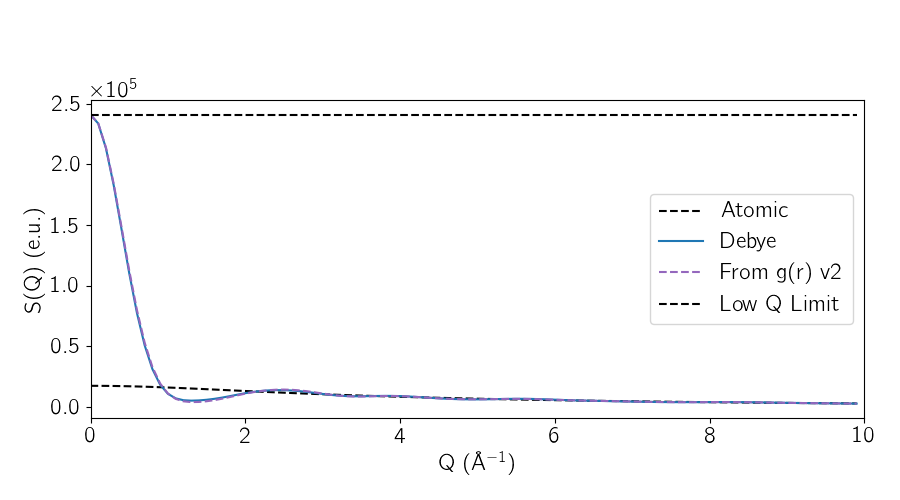

In [153]:
left = set([('-'.join(key[:2]), rdf.n1) for (key,rdf) in rdfs.items()])
right = set([('-'.join(key[2:]), rdf.n2) for (key,rdf) in rdfs.items()])
total_atom_types = left | right

s_atomic = np.zeros(len(qvec))
deb = Debye(qvec=qvec)
for atm, n in total_atom_types:
    element = atm.split('-')[0]
    s_atomic += n * deb.atomic_f0(element)**2


fig, ax = plt.subplots(1, 1, figsize=(9, 5)) 
ax.plot(deb.qvec, s_atomic, 'k--', label='Atomic')
ax.plot(deb.qvec, s_deb, 'C0', label='Debye')
ax.plot(deb.qvec, sg_2, 'C4--', label='From g(r) v2')
ax.plot(deb.qvec, np.ones_like(deb.qvec) * num_electrons_squared, 'k--', label='Low Q Limit')
ax.set_xlim([0, 10])
ax.set_xlabel('Q (Å$^{-1})$')
ax.set_ylabel('S(Q) (e.u.)')
ax.legend(loc='best');
fig.tight_layout()


The remaining difference scales linearly with dr in the RDF-sampling. You can check this by changing the `dr`in the vmd script and rerun the RDF sampling. 

However, smaller `dr` than the current value of 0.0001 makes the calculation _really_ slow, and the numerical integration (simply `sum * dr`) isn't good enough

<IPython.core.display.Javascript object>


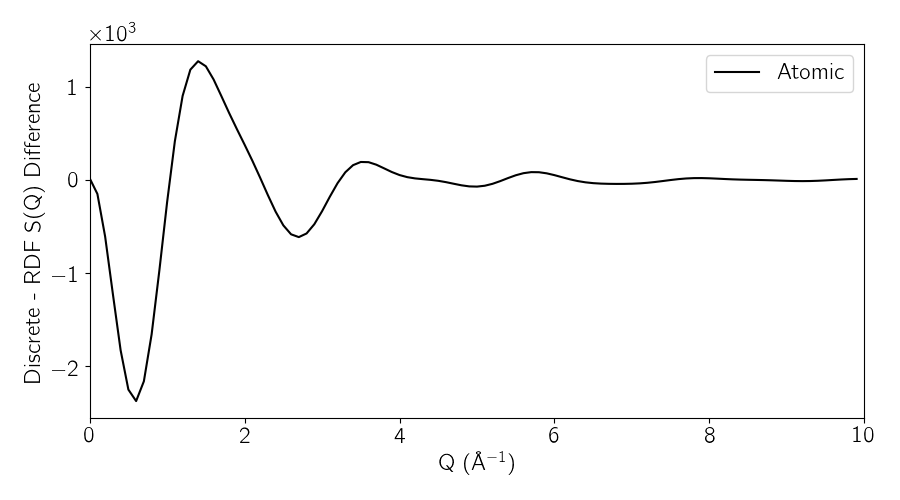

In [154]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5)) 
ax.plot(deb.qvec, s_deb - sg_2, 'k-', label='Atomic')
ax.set_xlim([0, 10])
ax.set_xlabel('Q (Å$^{-1})$')
ax.set_ylabel('Discrete - RDF S(Q) Difference')
ax.legend(loc='best');
fig.tight_layout()


### Water

In [129]:
rdfs = rdfset_from_dir('../data/test/xray_water/', '../data/md/water/waterbox_04096_amber.prmtop')
rdfs.show()

/opt/tljh/user/envs/py38/lib/python3.8/site-packages/MDAnalysis/topology/TOPParser.py:295: UserWarning: Unknown ATOMIC_NUMBER value found for some atoms, these have been given an empty element record. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn(msg)
/opt/tljh/user/envs/py38/lib/python3.8/site-packages/MDAnalysis/core/universe.py:159: UserWarning: No coordinate reader found for ../data/md/water/waterbox_04096_amber.prmtop. Skipping this file.
  warnings.warn('No coordinate reader found for {}. Skipping '


|  #  | KEY                   |     STOICHOMETRY     | REGION1, REGION2 | VOLUME 
| 000 | H-solvent--H-solvent  | N1:  8190, N2:  8190 | solvent, solvent | 122900.8521 |
| 001 | H-solvent--O-solvent  | N1:  8190, N2:  4095 | solvent, solvent | 122900.8521 |
| 002 | O-solvent--H-solvent  | N1:  4095, N2:  8190 | solvent, solvent | 122900.8521 |
| 003 | O-solvent--O-solvent  | N1:  4095, N2:  4095 | solvent, solvent | 122900.8521 |


Corrections

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


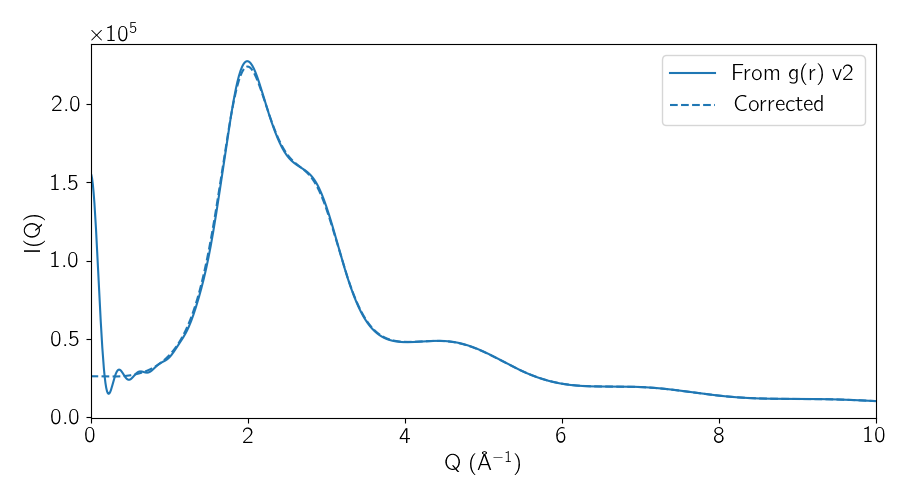

In [132]:
from cmm.xray.sgr2 import RDFSet, VolumeCorrect as VC
import copy

qvec = np.arange(0, 10, 0.01)
r_max = rdfs[0].r[-1]
corrected_set = RDFSet()
for key, rdf in rdfs.items():
    vc = VC(rdf, method='vegt')
    rdf_vc = copy.deepcopy(rdf)
    rdf_vc.g = vc.correct(0)  # doesn't need an input when using vegt
    rdf_vc.r_max = r_max
    rdf_vc.damp = Damping('simple', L=r_max)
    corrected_set[key] = rdf_vc
    
sg_2_corr = corrected_set.get_iq(qvec=qvec)
qvec = np.arange(0, 10, 0.01)

sg_2 = rdfs.get_iq(qvec=qvec)
fig, ax = plt.subplots(1, 1, figsize=(9, 5)) 
ax.plot(qvec, sg_2, 'C0-', label='From g(r) v2')
ax.plot(qvec, sg_2_corr, 'C0--', label='Corrected')
ax.set_xlim([0, 10])
ax.set_xlabel('Q (Å$^{-1})$')
ax.set_ylabel('I(Q)')
ax.legend(loc='best');
fig.tight_layout()

<IPython.core.display.Javascript object>


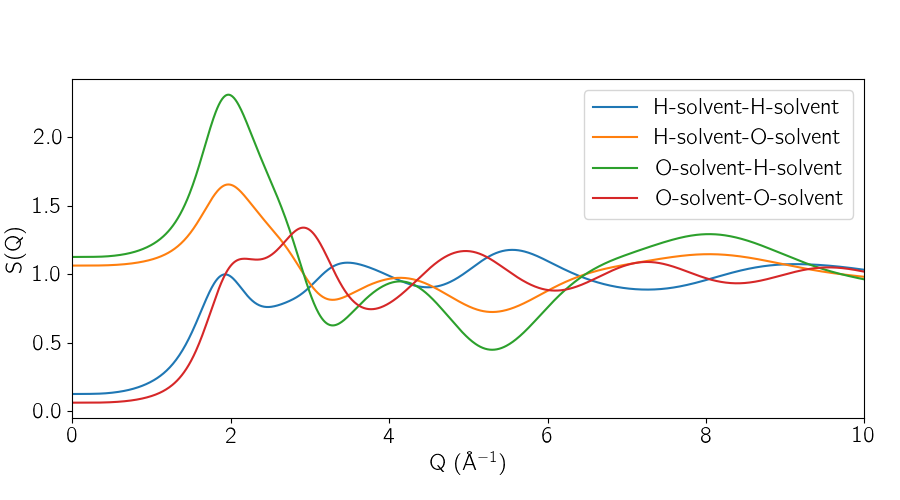

In [134]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5)) 
for key, rdf in corrected_set.items():
    lbl = '-'.join(key)
    ax.plot(qvec, rdf.s, label=lbl)
ax.set_xlim([0, 10])
ax.set_xlabel('Q (Å$^{-1})$')
ax.set_ylabel('S(Q)')
ax.legend(loc='best');

The structure factors for HO and OH are _not_ the same, because n2 is different in the two calculations. 

In [16]:
plt.close('all')